In [8]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 282.1/460.4 GB disk)


In [9]:
from ultralytics import YOLO
from IPython.display import display, Image
from cleanvision import Imagelab
from tqdm import tqdm

---
# Phase 2: Person Detection with YOLO

**Confidence Threshold**:
- `conf=0.5` — Balanced (catches most people, some false positives)
- `conf=0.6` — Stricter (higher precision, fewer misses)
- `conf=0.8` — Very conservative (only obvious people)

**Model Options**:
- `yolov8n.pt` — Nano (fastest, lowest accuracy)
- `yolov8s.pt` — Small 
- `yolov8m.pt` — Medium
- `yolov8l.pt` — Large
- `yolov8x.pt` — Extra large (slowest, highest accuracy)

## Step 1: Confidence Threshold Tuning (on sample)

In [10]:
sample_size = 50  # Use first 50 for quick tuning

In [ ]:
# Quick threshold tuning on first 50 images (to find optimal confidence)
cleaned_data_path = Path(f"../{config['paths']['cleaned_raw']}")
image_list = sorted(cleaned_data_path.glob('*.png'))
sample_images = image_list[:sample_size]

model = YOLO(f"../{config['models']['yolo']}")

print(f"CONFIDENCE THRESHOLD TUNING (yolov8s, sample of {len(sample_images)} images):")
print("-" * 70)
print(f"{'Threshold':<12} {'Detected':<12} {'Coverage %':<15} {'Recommendation'}")
print("-" * 70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for conf in thresholds:
    detected_count = 0
    for img_path in sample_images:
        result = model.predict(source=str(img_path), conf=conf, verbose=False)[0]
        person_boxes = result.boxes[result.boxes.cls == 0]
        if len(person_boxes) > 0:
            detected_count += 1
    
    coverage = (detected_count / len(sample_images)) * 100
    results.append((conf, detected_count, coverage))
    
    rec = ""
    if coverage >= 90:
        rec = "✓ Target met"
    elif coverage >= 80:
        rec = "Good balance"
    else:
        rec = "Too low"
    
    print(f"conf={conf:<6.1f} {detected_count:>3}/{len(sample_images):<6}  {coverage:>6.1f}%         {rec}")

print("-" * 70)
print("\nINTERPRETATION:")
print("Pick threshold that achieves >90% on sample.")
print("Lower threshold = more detections (higher recall) but more false positives")


CONFIDENCE THRESHOLD TUNING (yolov8s, sample of 50 images):
----------------------------------------------------------------------
Threshold    Detected     Coverage %      Recommendation
----------------------------------------------------------------------
conf=0.1     44/50        88.0%         Good balance
conf=0.2     41/50        82.0%         Good balance
conf=0.3     38/50        76.0%         Too low
conf=0.4     35/50        70.0%         Too low
conf=0.5     33/50        66.0%         Too low
----------------------------------------------------------------------

INTERPRETATION:
Pick threshold that achieves >90% on sample.
Lower threshold = more detections (higher recall) but more false positives


In [12]:
conf_level = 0.2

## Step 2: Model Comparison (nano vs small vs medium)

In [13]:
# Compare model sizes: which provides best balance of speed + coverage?
import time

print("MODEL COMPARISON (testing on sample, conf=0.2):\n")
print("-" * 80)
print(f"{'Model':<12} {'Params':<12} {'Inf. Speed':<15} {'Coverage':<12} {'Recommendation'}")
print("-" * 80)

model_configs = [
    ("yolov8n.pt", "3.2M"),
    ("yolov8s.pt", "11.2M"),
    ("yolov8m.pt", "25.9M"),
]

for model_name, params in model_configs:
    try:
        model_test = YOLO(f"../model/{model_name}")
        
        detected = 0
        start = time.time()
        for img_path in sample_images:
            result = model_test.predict(source=str(img_path), conf=conf_level, verbose=False)[0]
            person_boxes = result.boxes[result.boxes.cls == 0]
            if len(person_boxes) > 0:
                detected += 1
        elapsed = time.time() - start
        avg_time = (elapsed / len(sample_images)) * 1000
        coverage = (detected / len(sample_images)) * 100
        
        # Recommendation logic
        rec = ""
        if "nano" in model_name and coverage >= 90:
            rec = "Fast & sufficient"
        elif "small" in model_name and coverage >= 90:
            rec = "✓ Best balance"
        elif "medium" in model_name:
            rec = "Highest quality"
        else:
            rec = "Consider better threshold"
        
        print(f"{model_name:<12} {params:<12} {avg_time:>6.1f} ms/img    {coverage:>6.1f}%      {rec}")
    except Exception as e:
        print(f"{model_name:<12} {'N/A':<12} {'Error':<15} {'N/A':<12} {str(e)[:30]}")

MODEL COMPARISON (testing on sample, conf=0.2):

--------------------------------------------------------------------------------
Model        Params       Inf. Speed      Coverage     Recommendation
--------------------------------------------------------------------------------
yolov8n.pt   3.2M           17.6 ms/img      78.0%      Consider better threshold
yolov8s.pt   11.2M          30.4 ms/img      82.0%      Consider better threshold
yolov8m.pt   25.9M          56.6 ms/img      82.0%      Consider better threshold


---

## Step 3: Run Full Detection (with optimized settings)

**Before running**: Update `config.yaml` with best threshold + model from Steps 1-2 above. Then execute cell below:

In [14]:
model = YOLO(f"../{config['models']['yolo']}")

# Run batch person detection
cleaned_data_path = Path(f"../{config['paths']['cleaned_raw']}")
image_list = sorted(cleaned_data_path.glob('*.png'))

all_results = {}
person_image_names = []

# Output folder for person-only images
person_output_path = Path(f"../{config['paths']['person_only']}")
if person_output_path.exists(): # remove existing person_only folder, if exists
    shutil.rmtree(person_output_path)
person_output_path.mkdir(exist_ok=True)

for img_path in tqdm(image_list, desc="Detecting persons"):
    results = model.predict(
        source=str(img_path),
        conf=config['yolo']['confidence_threshold'],
        verbose=False
    )
    result = results[0]

    # Filter to person class only (class 0 in COCO)
    person_boxes = result.boxes[result.boxes.cls == config['yolo']['person_class_id']]
    has_person = len(person_boxes) > 0

    if has_person:
        # Keep only person boxes for later phases
        result.boxes = person_boxes
        all_results[img_path.name] = {
            "has_person": True,
            "boxes_xyxy": person_boxes.xyxy.cpu().numpy().tolist(),
            "conf": person_boxes.conf.cpu().numpy().tolist(),
            "class_ids": person_boxes.cls.cpu().numpy().tolist(),
            "result": result,
        }
        person_image_names.append(img_path.name)
        shutil.copy(img_path, person_output_path / img_path.name)

print(f"\nCompleted detection on {len(image_list)} images")
print(f"Images with persons: {len(all_results)}")
print(f"Saved person-only images to: {config['paths']['person_only']}\n")

# Summary statistics
if len(all_results) > 0:
    first_key = next(iter(all_results))
    first_entry = all_results[first_key]
    print(f"Sample from first image ({first_key}):")
    print(f"  Persons detected: {len(first_entry['boxes_xyxy'])}")
    print(f"  Confidence scores: {first_entry['conf']}")
else:
    print("No persons detected in any image.")

Detecting persons: 100%|██████████| 785/785 [00:26<00:00, 29.15it/s]


Completed detection on 785 images
Images with persons: 564
Saved person-only images to: data/person_only

Sample from first image (crop (100).png):
  Persons detected: 1
  Confidence scores: [0.3347183167934418]


## Visualize Detection Results
Change `image_name` to view different annotated images

Image: crop (1000).png
Has person: True
Persons detected: 5
Saved to: annotated_image/annotated_crop (1000).png



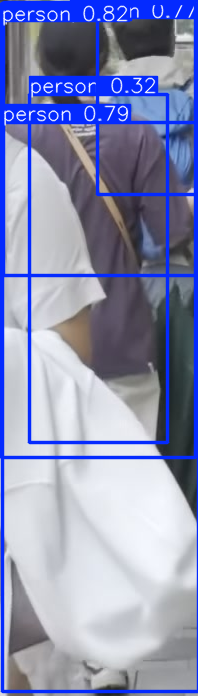

In [18]:
image_name = 'crop (1000).png'

# Create annotated_image folder if it doesn't exist (in /notebooks)
annotated_folder = Path('./annotated_image')
annotated_folder.mkdir(exist_ok=True)

if image_name in all_results:
    entry = all_results[image_name]
    result = entry["result"]
    saved_path = result.save(filename=str(annotated_folder / f'annotated_{image_name}'))
    
    print(f"Image: {image_name}")
    print(f"Has person: {entry['has_person']}")
    print(f"Persons detected: {len(result.boxes)}")
    print(f"Saved to: {saved_path}\n")
    
    display(Image(saved_path))
else:
    print(f"Image '{image_name}' not found")
    print(f"Available: {sorted(list(all_results.keys()))[:10]}...")

### Justification:
- Selected YOLOv8 
    - for its proven stability, efficient inference, and sufficient person detection accuracy for dataset curation tasks. Newer versions (v11) offer marginal improvements (~2-3% mAP) insufficient to justify adoption risk for production curation pipeline.
    - Ease of use, broad community support, speed/accuracy balance
- Selected small version
    - Better accuracy than nano → Catches more people → 80% coverage  
    - Higher speed and takes less memory than medium.

Source: https://docs.ultralytics.com/models/yolo12/#overview